In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random_state = 0
classifers = {
    "MLP": MLPClassifier(alpha=1, max_iter=1000, random_state=random_state),
    "KNN": KNeighborsClassifier(3),
    "SVC(liner)": SVC(kernel="linear", random_state=random_state),
    "SVC(sigmoid)": SVC(kernel="sigmoid", random_state=random_state),
    "SVC(rbf)": SVC(kernel="rbf", random_state=random_state),
    "SVC(gamma)": SVC(gamma=2, C=1, random_state=random_state),
    "GaussianProcessClassifier": GaussianProcessClassifier(1.0 * RBF(1.0), random_state=random_state), 
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=random_state),
    "RandomForest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=random_state),
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    "GaussianNB": GaussianNB(),
    "QuadratcDiscriminant": QuadraticDiscriminantAnalysis()
}

In [5]:
est = pd.read_csv("LungCancer10x/09_bulk/RNA_seq/MuSic/All_est.csv", index_col=0)
est.head()

,LUAD32,LUAD31,LUAD29,LUAD18,LUSC4,LUSC8,LUAD28,LUAD21,LUSC6,LUAD17,...,3023n_sq_yes_I_M_62,3023t_sq_yes_I_M_62,5011n_sq_yes_II_M_61,5011t_sq_yes_II_M_61,5012n_ad_yes_I_M_57,5012t_ad_yes_I_M_57,6029n_ad_yes_III_M_61,6029t_ad_yes_III_M_61,5014n_sq_yes_II_M_60,5014t_sq_yes_II_M_60
CD4,0.000000,0.000006,0.000000,0.000000,0.000000,0.029212,0.000000,0.000000,0.054242,0.000000,...,0.036763,0.000000,0.164699,0,0.000000,0.012389,0.025759,0.000000,0.000000,0.0
Mo,0.163785,0.056483,0.000000,0.000000,0.001925,0.000000,0.000000,0.046941,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.002531,0.0
NK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008443,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Mast,0.002807,0.057326,0.044838,0.002949,0.008618,0.041932,0.026097,0.001218,0.008455,0.032373,...,0.028958,0.000000,0.000006,0,0.003788,0.035911,0.011058,0.027189,0.006995,0.0
Gran,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044437,...,0.031324,0.001958,0.001861,0,0.015871,0.000687,0.000244,0.041601,0.001655,0.0


In [6]:
meta = pd.read_csv("LungCancer10x/09_bulk/RNA_seq/MuSic/All_est_meta.csv", index_col=0)
meta.head()

,Stage,Disease,Source
LUAD32,III,LUAD,In-house
LUAD31,I,LUAD,In-house
LUAD29,II,LUAD,In-house
LUAD18,III,LUAD,In-house
LUSC4,I,LUSC,In-house


remove SYSU data

In [48]:
meta = meta.loc[[x != "SYSU" for x in meta["Source"]], :]

In [7]:
def train_with_roc(classifer, X_train, y_train, X_test, y_test):
    u"""
    train data and calculate the roc and auc score
    :param classifer
    :param X_train:
    :param y_train:
    :param X_test:
    :param y_test
    """
    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(classifer)
    y_score = classifier.fit(X_train, y_train)
    
    if isinstance(classifer, SVC):
        y_score = y_score.decision_function(X_test)

    else:
        y_score = y_score.predict(X_test)
        
    fpr, tpr, threshs = roc_curve(y_test, y_score)    
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

In [8]:
def plot_roc_single(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    
def plot_roc_multi(scores, filename=None):
    plt.figure()
    lw = 2
    
    colors = sns.color_palette("Paired")
    colors += sns.color_palette("Set2")

    curr = 0
    for l, val in scores.items():
        plt.plot(val[0], val[1], color=colors[curr], lw=lw, label='%s: ROC (area = %0.2f)' % (l, val[2]))
        curr += 1

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

## SVM
### LUAD with Normal

Using TCGA, GTEx and inhouse to train, East asians to test 

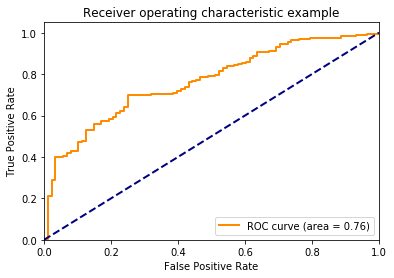

In [9]:
scores = {}
# Add noisy features to make the problem harder

temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "NL", "NL(AD)"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


temp_train = temp_meta.loc[[x  != "East Asians" for x in temp_meta["Source"]], ]
temp_pred = temp_meta.loc[[x == "East Asians" for x in temp_meta["Source"]], ]

fpr, tpr, roc_auc = train_with_roc(
    classifer=svm.SVC(kernel='sigmoid', gamma="auto", coef0=4.5, probability=True, random_state=random_state), 
    X_train=est.loc[:, temp_train.index].transpose(), 
    y_train=temp_train["Disease"],
    X_test=est.loc[:, temp_pred.index].transpose(),
    y_test=temp_pred["Disease"]
)

scores["LUAD vs. NL"] = [fpr, tpr, roc_auc]

plot_roc_single(fpr, tpr, roc_auc)

### LUSC with Normal

Using Inhouse data, TCGA and GTEx data, 40% to train and 60% to test

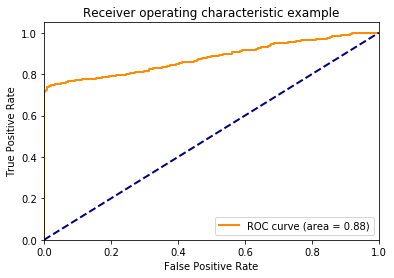

In [10]:
temp_meta = meta.loc[meta["Disease"].isin(["LUSC", "NL", "NL(SC)"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score

# X_train, X_test, y_train, y_test = train_test_split(
#     est.loc[:, temp_meta.index].transpose(), 
#     temp_meta["Disease"], 
#     test_size=.4, 
#     random_state=random_state
# )

random_select_gtex = temp_meta.loc[[x == "GTEx" for x in temp_meta["Source"]], ].sample(n = 20, random_state = random_state)
sel_train = []
for idx, x in temp_meta.iterrows():
    if x["Source"] == "In-house" or idx in set(random_select_gtex.index):
        sel_train.append(idx)

temp_train = temp_meta.loc[[x in sel_train for x in temp_meta.index], ]
temp_pred = temp_meta.loc[[x not in sel_train for x in temp_meta.index], ]


fpr, tpr, roc_auc = train_with_roc(
    classifer=svm.SVC(kernel='linear', probability=True, random_state=random_state), 
    X_train=est.loc[:, temp_train.index].transpose(), 
    y_train=temp_train["Disease"],
    X_test=est.loc[:, temp_pred.index].transpose(),
    y_test=temp_pred["Disease"]
)

scores["LUSC vs. NL"] = [fpr, tpr, roc_auc]

plot_roc_single(fpr, tpr, roc_auc)

### LUAD and LUSC
Using inhouse data to train, rest to test

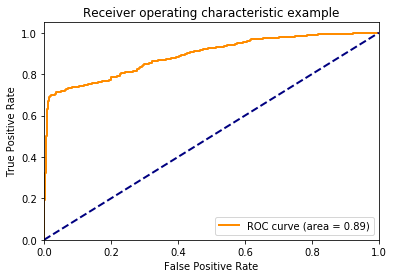

In [11]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "LUSC"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUAD":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


temp_train = temp_meta.loc[[x  == "In-house" for x in temp_meta["Source"]], ]
temp_pred = temp_meta.loc[[x != "In-house" for x in temp_meta["Source"]], ]


fpr, tpr, roc_auc = train_with_roc(
    classifer=svm.SVC(kernel='linear', probability=True, random_state=random_state), 
    X_train=est.loc[:, temp_train.index].transpose(), 
    y_train=temp_train["Disease"],
    X_test=est.loc[:, temp_pred.index].transpose(),
    y_test=temp_pred["Disease"]
)

scores["LUAD vs. LUSC"] = [fpr, tpr, roc_auc]

plot_roc_single(fpr, tpr, roc_auc)

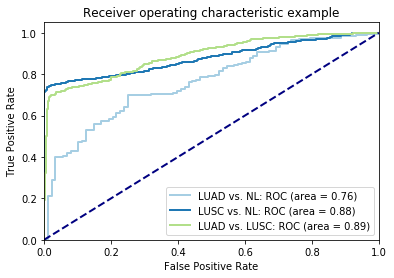

In [12]:
plot_roc_multi(scores)

## Test on different classifers

### Test all classifer on LUAD vs NL

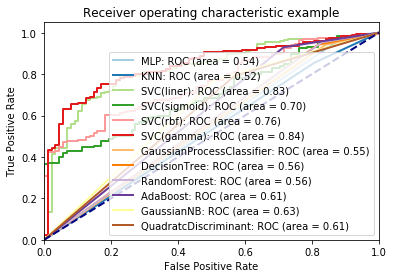

In [13]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "NL", "NL(AD)"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


temp_train = temp_meta.loc[[x  != "East Asians" for x in temp_meta["Source"]], ]
temp_pred = temp_meta.loc[[x == "East Asians" for x in temp_meta["Source"]], ]

for lab, classifer in classifers.items():
    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=est.loc[:, temp_train.index].transpose(), 
        y_train=temp_train["Disease"],
        X_test=est.loc[:, temp_pred.index].transpose(),
        y_test=temp_pred["Disease"]
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores, filename="LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_NL.pdf")

### Test all classifer on LUSC vs NL

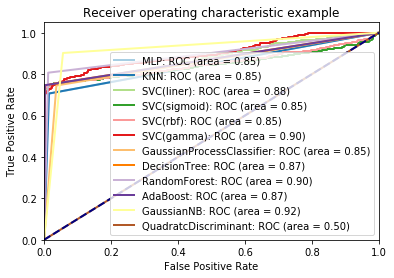

In [14]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUSC", "NL", "NL(SC)"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score

random_select_gtex = temp_meta.loc[[x == "GTEx" for x in temp_meta["Source"]], ].sample(n = 20, random_state = random_state)
sel_train = []
for idx, x in temp_meta.iterrows():
    if x["Source"] == "In-house" or idx in set(random_select_gtex.index):
        sel_train.append(idx)

temp_train = temp_meta.loc[[x in sel_train for x in temp_meta.index], ]
temp_pred = temp_meta.loc[[x not in sel_train for x in temp_meta.index], ]


for lab, classifer in classifers.items():
    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=est.loc[:, temp_train.index].transpose(), 
        y_train=temp_train["Disease"],
        X_test=est.loc[:, temp_pred.index].transpose(),
        y_test=temp_pred["Disease"]
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores, filename="LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_SC_NL.pdf")

### LUAD vs LUSC

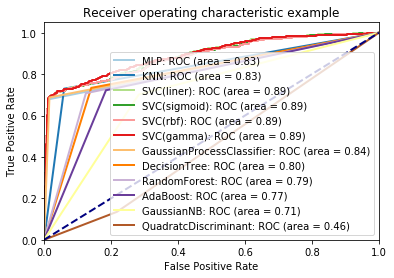

In [15]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "LUSC"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUAD":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


temp_train = temp_meta.loc[[x  == "In-house" for x in temp_meta["Source"]], ]
temp_pred = temp_meta.loc[[x != "In-house" for x in temp_meta["Source"]], ]


for lab, classifer in classifers.items():
    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=est.loc[:, temp_train.index].transpose(), 
        y_train=temp_train["Disease"],
        X_test=est.loc[:, temp_pred.index].transpose(),
        y_test=temp_pred["Disease"]
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores, filename="LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_SC.pdf")

## Multiple times 

In [16]:
def make_roc_plots(scores, filename = None):
    
    # format data
    data_plot = []
    roc_vals = []
    for k, val in scores.items():
        temp = pd.DataFrame({"x": val[0], "y": val[1], "label": ["R%s" % k for _ in range(len(val[0]))]})
        data_plot.append(temp)
        roc_vals.append(val[2])

    data_plot = pd.concat(data_plot)
    
    # make plot
    fig, ax = plt.subplots()
    sns.set(style="whitegrid")
    sns.lineplot(
        x="x", y="y",
        hue="label", 
        palette="tab10",
        data=data_plot,
        ax = ax
    )
    ax.text(0.65, 0.15,'AUC (mean): %0.2f' % np.mean(roc_vals), fontsize=12) #add text
    ax.text(0.65, 0.05,'AUC (SD): %0.4f' % np.std(roc_vals), fontsize=12) #add text
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.get_legend().remove()
    
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

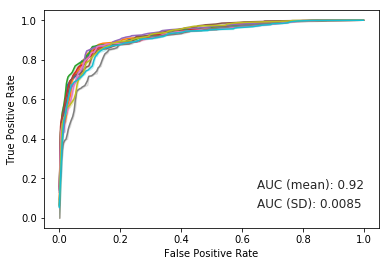

In [17]:
total_scores = {}
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "NL", "NL(AD)"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
    
total_scores["AD vs NL"] = scores
   
make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_NL.pdf")

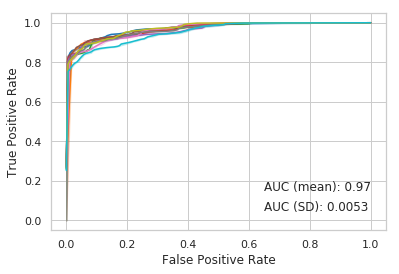

In [18]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUSC", "NL", "NL(SC)"]), ]
disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]

total_scores["SC vs NL"] = scores
    
make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_SC_NL.pdf")

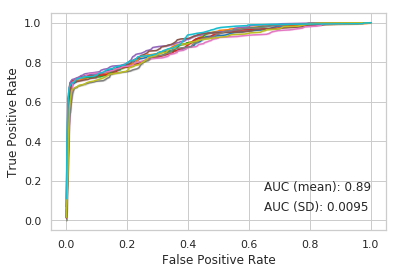

In [19]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "LUSC"]), ]
scores = {}
disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUAD":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]

total_scores["AD vs SC"] = scores    

make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_SC.pdf")

Make AUC plot

In [20]:
def make_roc_plots(scores, filename = None):
    
    # format data
    data_plot = []
    roc_vals = []
    for k, val in scores.items():
        temp = pd.DataFrame({"x": val[0], "y": val[1], "label": ["R%s" % k for _ in range(len(val[0]))]})
        data_plot.append(temp)
        roc_vals.append(val[2])

    data_plot = pd.concat(data_plot)
    
    # make plot
    fig, ax = plt.subplots()
    sns.set(style="whitegrid")
    sns.lineplot(
        x="x", y="y",
        hue="label", 
        palette="tab10",
        data=data_plot,
        ax = ax
    )
    ax.text(0.65, 0.15,'AUC (mean): %0.2f' % np.mean(roc_vals), fontsize=12) #add text
    ax.text(0.65, 0.05,'AUC (SD): %0.4f' % np.std(roc_vals), fontsize=12) #add text
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.get_legend().remove()
    
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [23]:
data_plot = []
for k, data in total_scores.items():
    for r, val in data.items():
        temp = pd.DataFrame({
            "x": val[0], "y": val[1], 
            "repeat": ["R%s" % r for _ in range(len(val[0]))], 
            "AUC": [val[2] for _ in range(len(val[0]))],
            "label": [k for _ in range(len(val[0]))]
        })
        data_plot.append(temp)

data_plot = pd.concat(data_plot)
data_plot.head()

,x,y,repeat,AUC,label
0,0.000000,0.000000,R0,0.928602,AD vs NL
1,0.000000,0.002488,R0,0.928602,AD vs NL
2,0.000000,0.171642,R0,0.928602,AD vs NL
3,0.004587,0.171642,R0,0.928602,AD vs NL
4,0.004587,0.310945,R0,0.928602,AD vs NL


In [24]:
data_plot.to_csv("LungCancer10x/09_bulk/RNA_seq/MuSic/roc_auc_score.csv")

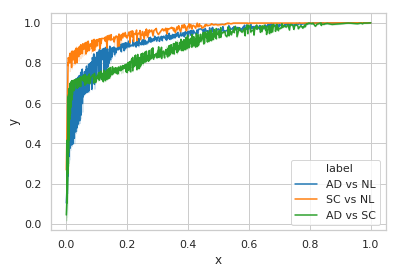

In [25]:
fig, ax = plt.subplots()
sns.set(style="whitegrid")



sns.lineplot(
    x="x", y="y",
    hue="label", 
    palette="tab10",
    data=data_plot,
    ax = ax
)

### Test on Stage

#### LUAD
I vs rest

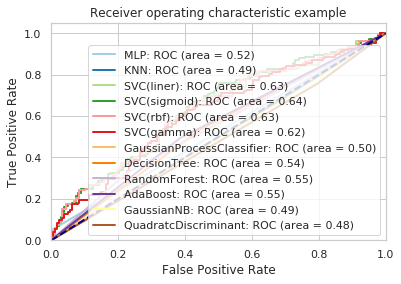

In [45]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUAD"]), ]
scores = {}
disease_score = []
for i in temp_meta["Stage"]:
    if i == "I":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Stage"] = disease_score

X_train, X_test, y_train, y_test = train_test_split(
    est.loc[:, temp_meta.index].transpose(), 
    temp_meta["Stage"], 
    test_size=.4, 
    random_state=0
)

for lab, classifer in classifers.items():

    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_I_vs_rest.pdf")

LUAD I, II vs III, IV

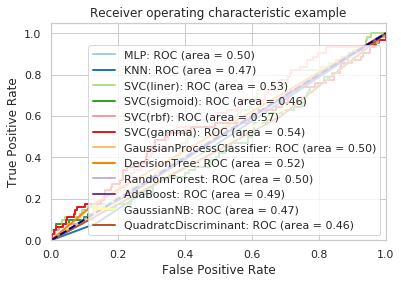

In [43]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUAD"]), ]

scores = {}

disease_score = []
for i in temp_meta["Stage"]:
    if i in ["I", "II"]:
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Stage"] = disease_score


X_train, X_test, y_train, y_test = train_test_split(
    est.loc[:, temp_meta.index].transpose(), 
    temp_meta["Stage"], 
    test_size=.4, 
    random_state=0
)

for lab, classifer in classifers.items():

    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_early_vs_advanced.pdf")

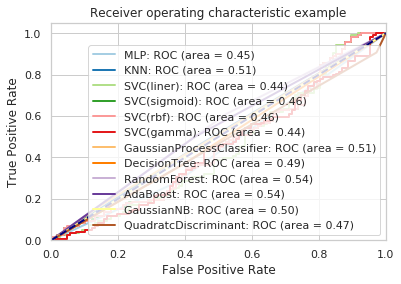

In [42]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUSC"]), ]
scores = {}
disease_score = []
for i in temp_meta["Stage"]:
    if i == "I":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Stage"] = disease_score

X_train, X_test, y_train, y_test = train_test_split(
    est.loc[:, temp_meta.index].transpose(), 
    temp_meta["Stage"], 
    test_size=.4, 
    random_state=0
)

for lab, classifer in classifers.items():

    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_SC_I_vs_rest.pdf")

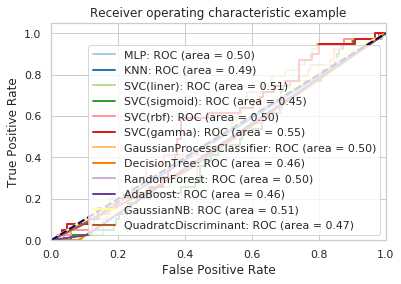

In [44]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUSC"]), ]
scores = {}
disease_score = []
for i in temp_meta["Stage"]:
    if i in ["I", "II"]:
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Stage"] = disease_score

X_train, X_test, y_train, y_test = train_test_split(
    est.loc[:, temp_meta.index].transpose(), 
    temp_meta["Stage"], 
    test_size=.4, 
    random_state=0
)

for lab, classifer in classifers.items():

    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_SC_early_vs_advanced.pdf")

Test with balanced data

In [69]:
meta.loc[meta["Disease"].isin(["LUAD"]), ].groupby("Stage").count()

,Disease,Source
Stage,,
I,563,563
II,228,228
III,195,195
IV,46,46


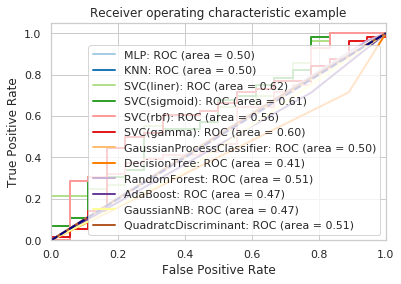

In [78]:
# Add noisy features to make the problem harder
meta["Sample"] = meta.index
temp_meta = meta.loc[meta["Disease"].isin(["LUAD"]), ].groupby('Stage').apply(lambda x: x.sample(n=46, random_state = 0)).reset_index(drop=True)
temp_meta.index = temp_meta["Sample"]

scores = {}
disease_score = []
for i in temp_meta["Stage"]:
    if i == "I":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Stage"] = disease_score

X_train, X_test, y_train, y_test = train_test_split(
    est.loc[:, temp_meta.index].transpose(), 
    temp_meta["Stage"], 
    test_size=.4, 
    random_state=0
)

for lab, classifer in classifers.items():

    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores)

In [79]:
meta.loc[meta["Disease"].isin(["LUSC"]), ].groupby("Stage").count()

,Disease,Source,Sample
Stage,,,
I,356,356,356
II,274,274,274
III,149,149,149
IV,10,10,10


In [ ]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUSC"]), ].groupby('Stage').apply(lambda x: x.sample(n=10, random_state = 0)).reset_index(drop=True)
temp_meta.index = temp_meta["Sample"]
scores = {}
disease_score = []
for i in temp_meta["Stage"]:
    if i == "I":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Stage"] = disease_score

X_train, X_test, y_train, y_test = train_test_split(
    est.loc[:, temp_meta.index].transpose(), 
    temp_meta["Stage"], 
    test_size=.4, 
    random_state=0
)

for lab, classifer in classifers.items():

    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores)

## Test with SYSU

In [61]:
meta = pd.read_csv("LungCancer10x/09_bulk/RNA_seq/MuSic/All_est_meta.csv", index_col=0)

LUAD vs LUSC

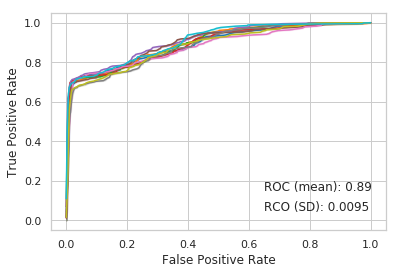

In [63]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "LUSC"]), ]
scores = {}
disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUAD":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores)

LUAD vs NL

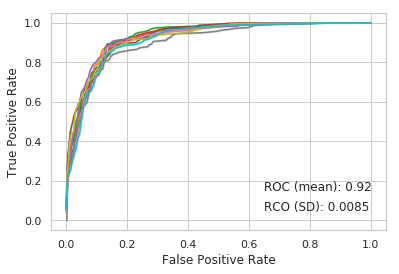

In [64]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "NL", "NL(AD)"]), ]
scores = {}
disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUAD":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores)

LUSC vl NL

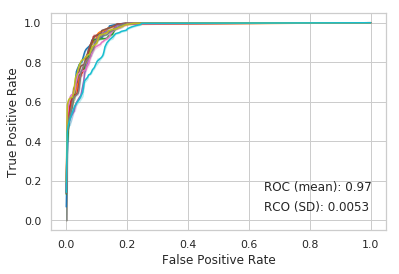

In [65]:
# Add noisy features to make the problem harder
temp_meta = meta.loc[meta["Disease"].isin(["LUSC", "NL"]), ]
scores = {}
disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUSC":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores)

Using SYSU as test set, rest as train set

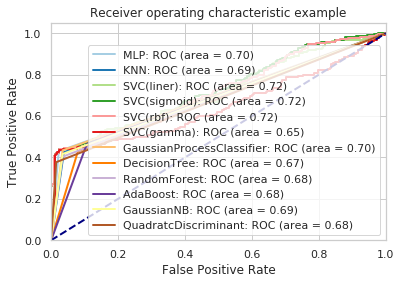

In [66]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "LUSC"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUAD":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


temp_train = temp_meta.loc[[x  != "SYSU" for x in temp_meta["Source"]], ]
temp_pred = temp_meta.loc[[x == "SYSU" for x in temp_meta["Source"]], ]

for lab, classifer in classifers.items():
    fpr, tpr, roc_auc = train_with_roc(
        classifer=classifer, 
        X_train=est.loc[:, temp_train.index].transpose(), 
        y_train=temp_train["Disease"],
        X_test=est.loc[:, temp_pred.index].transpose(),
        y_test=temp_pred["Disease"]
    )

    scores[lab] = [fpr, tpr, roc_auc]
   
plot_roc_multi(scores)

## Test AUC/ROC on immune and non-immune separately

In [83]:
immune = ["B", "CD4", "CD8","DC", "Mast", "Mo", "NK", "Tregs", "Gran"]

In [84]:
immune_est = est.loc[immune, :]
non_immune_est = est.loc[[x not in immune for x in est.index], :]

### LUAD vs NL

#### Immune

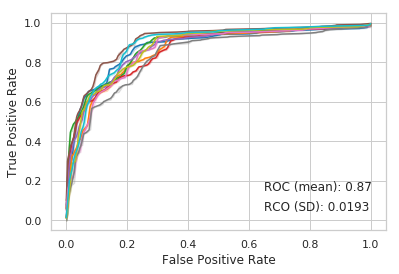

In [85]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "NL", "NL(AD)"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        immune_est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_NL_immune.pdf")

#### Non immune

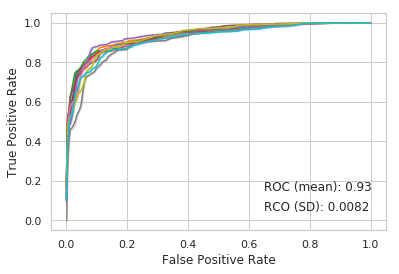

In [86]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "NL", "NL(AD)"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        non_immune_est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_NL_non_immune.pdf")

### LUSC vs NL

#### Immune

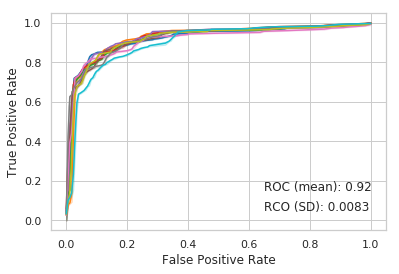

In [89]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUSC", "NL"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        immune_est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_SC_NL_immune.pdf")

#### Non immune

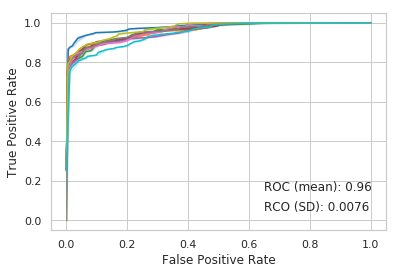

In [90]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUSC", "NL"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        non_immune_est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_SC_NL_non_immune.pdf")

### LUAD vs LUSC

#### Immune

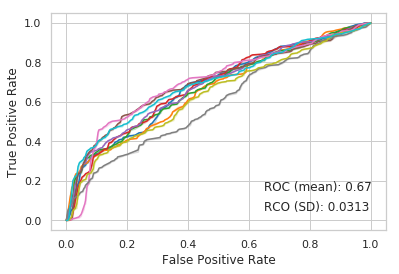

In [92]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUSC", "LUAD"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUAD":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        immune_est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_SC_immune.pdf")

#### Non immune

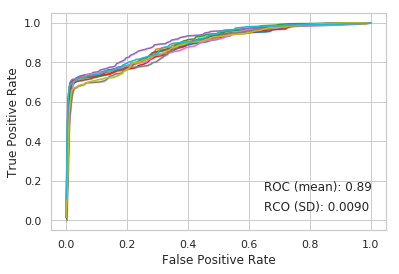

In [94]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUSC", "LUAD"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i == "LUAD":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        non_immune_est.loc[:, temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )

    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    scores[i] = [fpr, tpr, roc_auc]
   
make_roc_plots(scores, "LungCancer10x/09_bulk/RNA_seq/MuSic/ROC_AD_SC_non_immune.pdf")

## Test importance variable
### LUAD vs NL

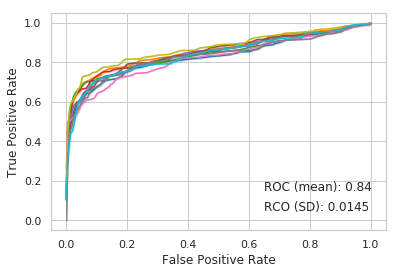

In [125]:
scores = {}
temp_meta = meta.loc[meta["Disease"].isin(["LUAD", "NL", "NL(AD)"]), ]

disease_score = []
for i in temp_meta["Disease"]:
    if i.split("(")[0] == "NL":
        disease_score.append(0)
    else:
        disease_score.append(1)
temp_meta["Disease"] = disease_score


coefs = []
labels = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        est.loc[["ATII", "Epi", "Basal"], temp_meta.index].transpose(), 
        temp_meta["Disease"], 
        test_size=.4, 
        random_state=i
    )
    
    fpr, tpr, roc_auc = train_with_roc(
        classifer=SVC(kernel="rbf", random_state=i), 
        X_train=X_train, 
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    
    scores[i] = [fpr, tpr, roc_auc]
    
make_roc_plots(scores)

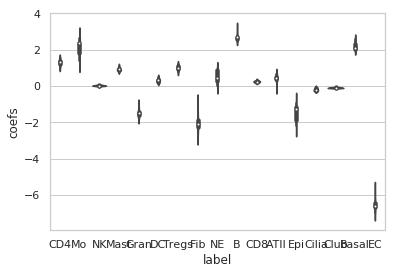